In [363]:
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from scipy.optimize import fsolve
from graph import *
from tqdm import tqdm

docs by names (62, 108) 108
docs by names (111, 108) 108


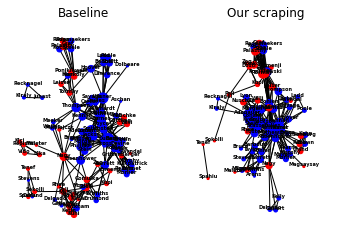

<Figure size 432x288 with 0 Axes>

Intersection, length:  172
dulles->kohler
konkoly->steele
barnes->wisner
bohlen->wisner
brown->dulles
phillips->stassen
graf->koch
barbour->kohler
palasthy->rademaekers
adenauer->jackson
barrett->mcgurn
meyer->morner
bross->dulles
stassen->stein
bruce->foster
kyes->morgan
koch->rademaekers
eisenhower->jackson
lyon->nuschke
morner->rearns
graf->popa
bross->jackson
foster->willi
graf->steele
adenauer->kyes
savage->thompson
ermenji->zog
konkoly->rademaekers
foster->jackson
dosti->pali
dulles->kyes
morgan->smith
phillips->stein
spahiu->tenef
bohlen->smith
hier->leiser
joyce->wisner
thompson->tormay
morner->murphy
joyce->smith
hier->tormay
conant->kyes
adenauer->conant
kadar->nagy
gomulka->mcgurn
carter->thompson
delgado->gellert
barrett->griffiths
poole->wisner
hier->ponikiewski
maleter->nagy
adenauer->dulles
joyce->mathews
barnes->thompson
dulles->jackson
lyon->willi
mathews->wisner
barnes->ravndal
joyce->kohler
dulles->phillips
dulles->meyer
barbour->dulles
ponikiewski->tormay
reinhardt-

In [364]:
'''
build network from adjacency matrix

'''

# %load graph.py
from numpy import genfromtxt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sys

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
np.set_printoptions(threshold=sys.maxsize)

def getfreqmatrix(filename):
    df = pd.read_csv(filename)
    names = list(df.columns)[1:]
    rownames = list(df["id"])  
    mydata = genfromtxt(filename, delimiter=',')
    mydata = mydata[1:,1:]
    return (names, rownames, mydata)


# M is a frequency matrix rows=documents, columns=names
def make_adjacency_matrix(M, names):
    n = len(names)
    print("docs by names", M.shape, n)
    A = np.zeros(n * n).reshape((n,n))
    for doc in M:
        for i in range(n):
            if doc[i] != 0:
                for j in range(i+1, len(doc)):
                    if doc[j] != 0:
                        A[i][j] += 1
                        A[j][i] += 1
    return A

# graph from adjacency matrix names by names
def nx_graph_from_adjacency_matrix(M, names, df, fig):
    V = names

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(V, nodetype="green")

    # Find the non-zero indices in the biadjacency matrix to connect those nodes
    G.add_edges_from([ (V[i], V[j]) for i, j in zip(*M.nonzero()) ])
    
    # formatting
    # pos = nx.random_layout(G, seed=490)
    pos = nx.spring_layout(G, seed=101, k=0.3, iterations=35)
    # remove isolated nodes
    
    ### This code removes nodes that are not connected
    #deg = G.degree()
    #to_remove = [n[0] for n in deg if n[1] == 0]
    #G.remove_nodes_from(to_remove)

    #colors = [float(G.degree(n)) for n in G]
    sizes = [float(G.degree(n))*5 for n in G] 
    labels = {}
    for n in G.nodes():
        if G.degree(n) > 0:
            s = n[0].upper() + n[1:]
            labels[n] = s

    colors = []
    for n in G:
        r = df.loc[df["lastname"].str.lower() == n]
        if r.iloc[0]['affiliation'] == "west":
            colors.append("blue")
        elif r.iloc[0]['affiliation'] == "east":
            colors.append("red")
        else:
            colors.append("grey")
        pass

    nx.draw(G, pos=pos, node_color=colors, node_size=sizes, with_labels=False)
    nx.draw_networkx_labels(G, pos, labels, font_size=5, 
            font_weight="bold", verticalalignment="bottom")
    f = plt.figure(fig)
    return (G, f)

# Adjust appearance of the nodes, edges, labels, etc.
def adjust_appearance_bipartite(G, pos):
    # Shift labels up off of their node
    textPos = pos.copy()
    for k in textPos:
        textPos[k][1] += .01

    labels = {}    
    for n in G.nodes():
        # Dont label documents, and only label figures with
        # a decently high degree 
        if ".txt" not in n and G.degree(n) > 2:
            s = n[0].upper() + n[1:]
            labels[n] = s
    nx.draw_networkx_labels(G, textPos, labels, font_size=10,  font_weight="bold",
                            verticalalignment="bottom")


# makes bipartite graph from documents to people
def nx_graph_from_biadjacency_matrix(M, txtfiles, names):

    U = txtfiles
    V = names

    # Create the graph and add each set of nodes
    G = nx.Graph()
    G.add_nodes_from(U, bipartite=0, nodetype="doc", nodesize=200, nodelabel=False)
    G.add_nodes_from(V, bipartite=1, nodetype="person", nodesize=50, nodelabel=True)

    # Find the non-zero indices in the biadjacency matrix to connect those nodes
    G.add_edges_from([ (U[i], V[j]) for i, j in zip(*M.nonzero()) ])
    
    # remove isolated nodes
    deg = G.degree()
    to_remove = [n[0] for n in deg if n[1] == 0]
    G.remove_nodes_from(to_remove)

    # Sets the colors of the nodes
    types= G.nodes(data="nodetype")
    print(types)
    colors = []
    for elm in types:
        print(elm)
        (n, typ) = elm
        degree = G.degree(n)
        if typ == "person":
            colors.append(float(degree))
        else:
            colors.append(-10.0)
    
    # formatting
    #colors = [float(G.degree(n)) for n in G]
    sizes = [u[1] for u in G.nodes(data="nodesize")]
    pos = nx.spring_layout(G, seed=101, k=0.1, iterations=15)
    nx.draw(G, pos=pos, node_size = sizes, with_labels=False, node_color = colors, edgecolors='black')

    adjust_appearance_bipartite(G, pos)

    plt.show()
    return G


# given set of edges, print them nicely
def format_edges(edges):
    for edge in list(edges):
        (n1, n2) = edge
        print(n1 + "->" + n2)

# given two graphs, returns jaccard index
def get_jaccard_index(G, H):
    A = set(G.edges)
    B = set(H.edges)
    n11 = A.intersection(B)   
    n10 = A.difference(B)
    n01 = B.difference(A)
    print("Intersection, length: ", len(n11))
    format_edges(n11)
    print("\n In our graph, not in baseline, length:", len(n10))
    format_edges(n10)
    print("\n In baseline, not in our Graph, length:", len(n01))
    format_edges(n01)
    return len(n11) / (len(n11) + len(n01) + len(n10))

def get_scraped_graph():
    namesdf = pd.read_csv("names.csv")
    (names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
    basemat = make_adjacency_matrix(basedata, names)
    (baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 2)
    return (baseG, basef)

if __name__ == "__main__":
    namesdf = pd.read_csv("names.csv")

    plt.subplot(1, 2, 1)
    (names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
    basemat = make_adjacency_matrix(basedata, names)
    (baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 1)
    plt.title('Baseline')
    

    plt.subplot(1, 2, 2)
    plt.title('Our scraping')
    (names, txtfiles, mydata) = getfreqmatrix("frequency.csv")  
    A = make_adjacency_matrix(mydata, names)
    (G, f1) = nx_graph_from_adjacency_matrix(A, names, namesdf, 2)
    # nx_graph_from_biadjacency_matrix(mydata, txtfiles, names)

    plt.show()

    J = get_jaccard_index(G, baseG)
    print("Jaccard index: ", J)

docs by names (62, 108) 108


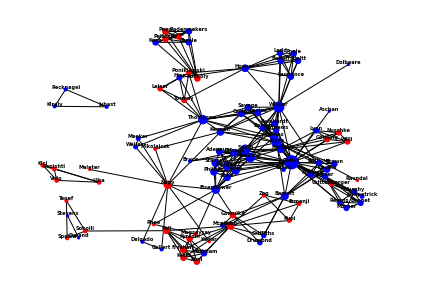

In [365]:
(names, ids, basedata) = getfreqmatrix("baseline/baseline_frequency.csv")
basemat = make_adjacency_matrix(basedata, names)
(baseG, basef) = nx_graph_from_adjacency_matrix(basemat, names, namesdf, 1)

In [366]:
'''
for group in groups:
    if group == 1:
        color_map.append('red')
    elif group == 2:
        color_map.append('orange')
    elif group == 3:
        color_map.append('yellow')
    elif group == 4:
        color_map.append('green')
    elif group == 5:
        color_map.append('blue')
    elif group == 6:
        color_map.append('purple')
    else: 
        color_map.append('pink')      
'''
groups[22]
#names[21]

7

In [379]:
color_map = []
groups = [3,7,6,6,2,6,4,6,6,6,6,6,2,3,2,7,7,6,7,5,6,1,7,3,5,6,5,7,7,6,5,6,6,6,4,4,3,2,7,7,7,7,2,5,7,7,6,7,6,7,5,5,5,3,5,4,4,4,6,7,7,5,6,6,7,6,7,3,6,6,7,6,7,7,5,5,3,4,4,5,5,7,7,6,7,6,7,7,2,4,3,7,7,3,5,3,7,7,7,2,4,7,7,7,7,6,2,5]

pos = nx.circular_layout(baseG)
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple', 'pink']
angs = np.linspace(0, 2*np.pi, len(colors))
repos = []
rad = 3
repos.append(np.array([0, 0]))
for ea in angs:
    if ea > 0:
        print(rad*np.cos(ea), rad*np.sin(ea))  # location of each cluster
        repos.append(np.array([rad*np.cos(ea), rad*np.sin(ea)]))
        
df = namesdf        
colors = []
for n in baseG:
    r = df.loc[df["lastname"].str.lower() == n]
    if r.iloc[0]['affiliation'] == "west":
        colors.append("white")
    elif r.iloc[0]['affiliation'] == "east":
        colors.append("red")
    else:
        colors.append("grey")

for i in range(len(groups)):
    group = groups[i]
    name = names[i]
    if group == 1:
        color = 'red'
        color_map.append('red')
        posx = 0
    elif group == 2:
        color = 'orange'
        color_map.append('orange')
        posx = 1
    elif group == 3:
        color = 'yellow'
        color_map.append('yellow')
        posx = 2
    elif group == 4:
        color = 'green'
        color_map.append('green')
        posx = 3
    elif group == 5:
        color = 'blue'
        color_map.append('blue')
        posx = 4
    elif group == 6:
        color = 'purple'
        color_map.append('purple')
        posx = 5
    elif group == 7:
        color = 'pink'
        color_map.append('pink') 
        posx = 6
    pos[name] += repos[posx]
    

    
    G.nodes()[name]['nodetype'] = color
    G.nodes()[name]['fillcolor'] = colors[i]
    G.nodes()[name]['style']='filled'

# --- End_myhack ---

1.5000000000000004 2.598076211353316
-1.4999999999999993 2.5980762113533165
-3.0 3.6739403974420594e-16
-1.5000000000000013 -2.598076211353315
1.4999999999999978 -2.598076211353317
3.0 -7.347880794884119e-16


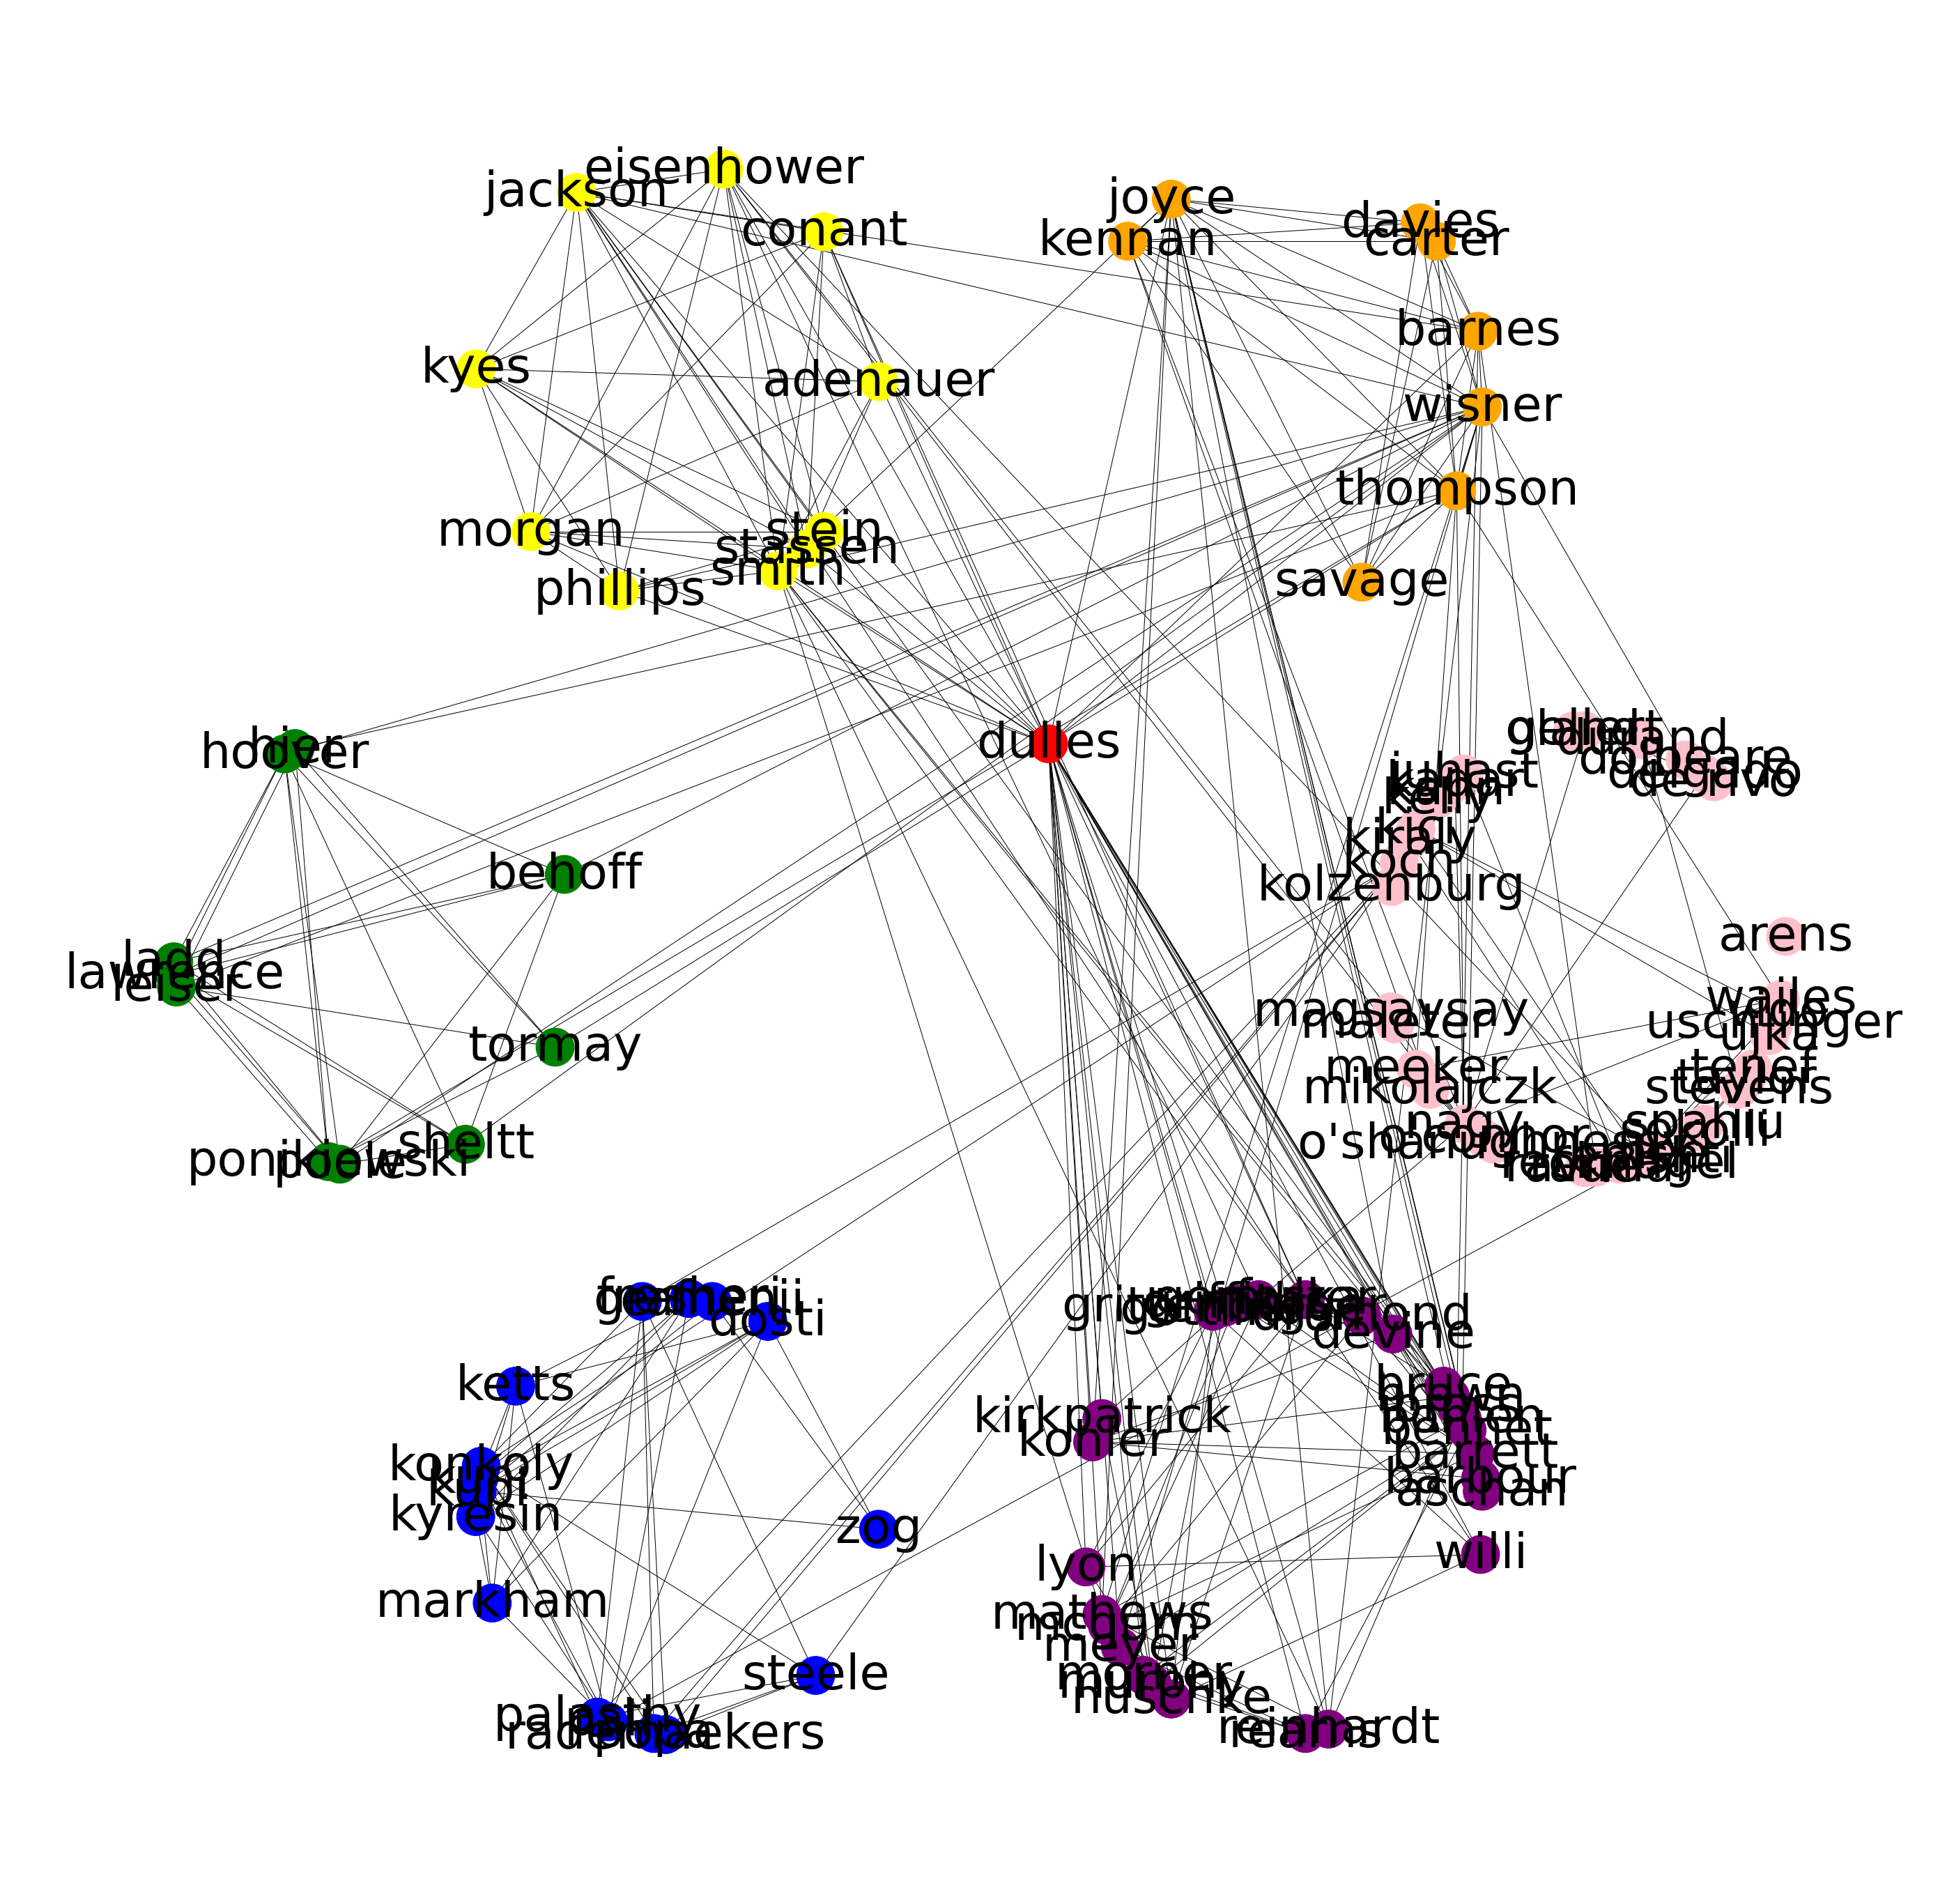

In [392]:

fig, ax = plt.subplots(figsize=(50,50))
nx.draw(baseG, node_color=color_map, node_size=3000, font_size=70, pos=pos, with_labels=True)
plt.show()

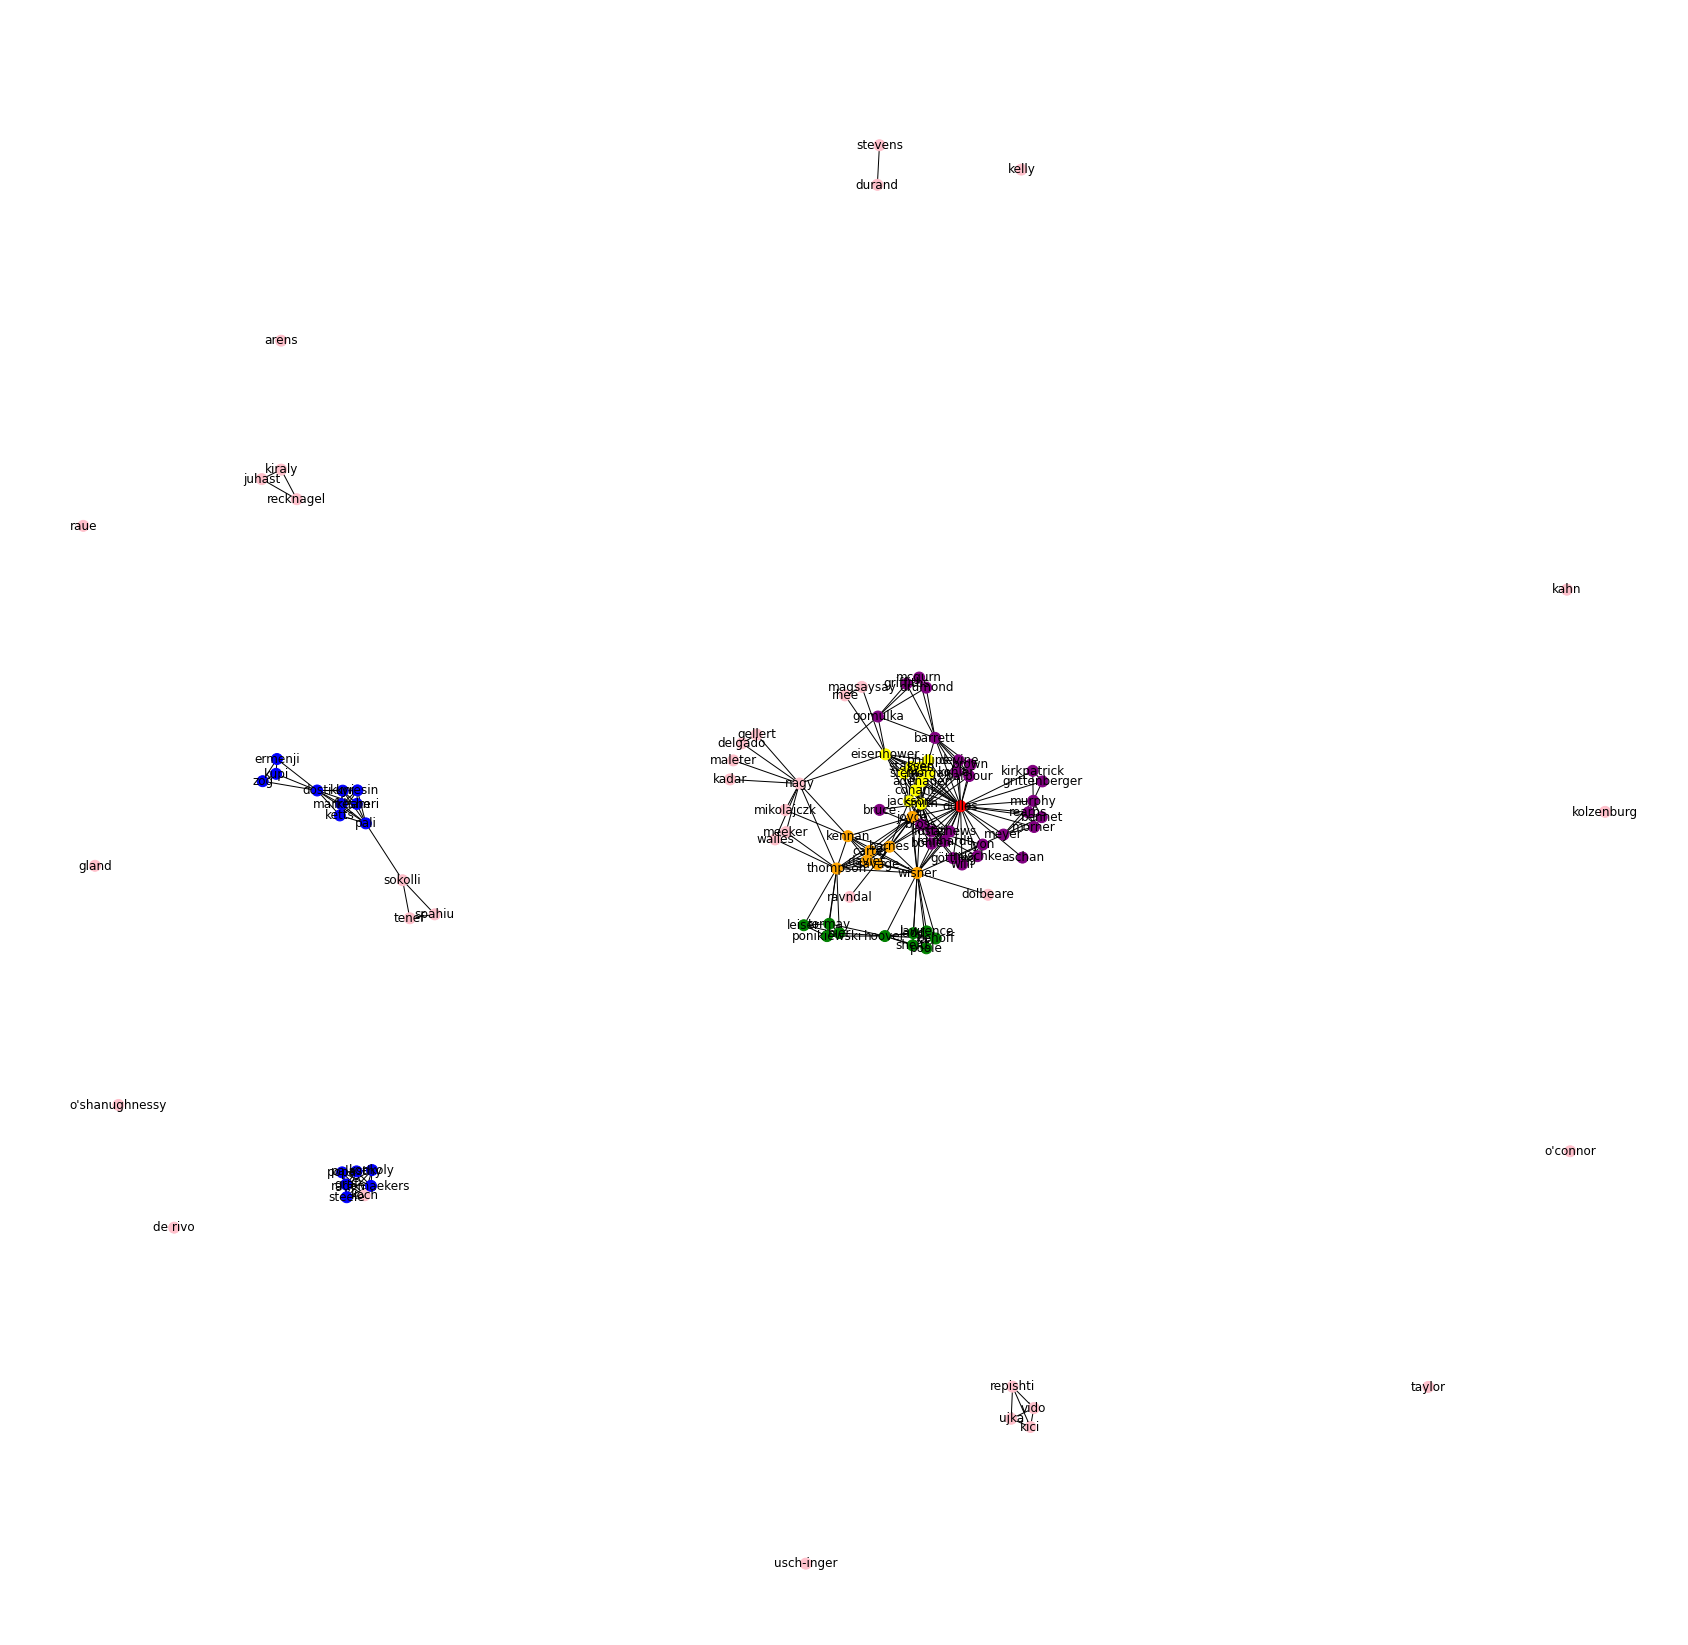

In [381]:
fig, ax = plt.subplots(figsize=(30,30))
nx.draw(baseG, node_color=color_map, node_size=120, with_labels=True)
plt.show()

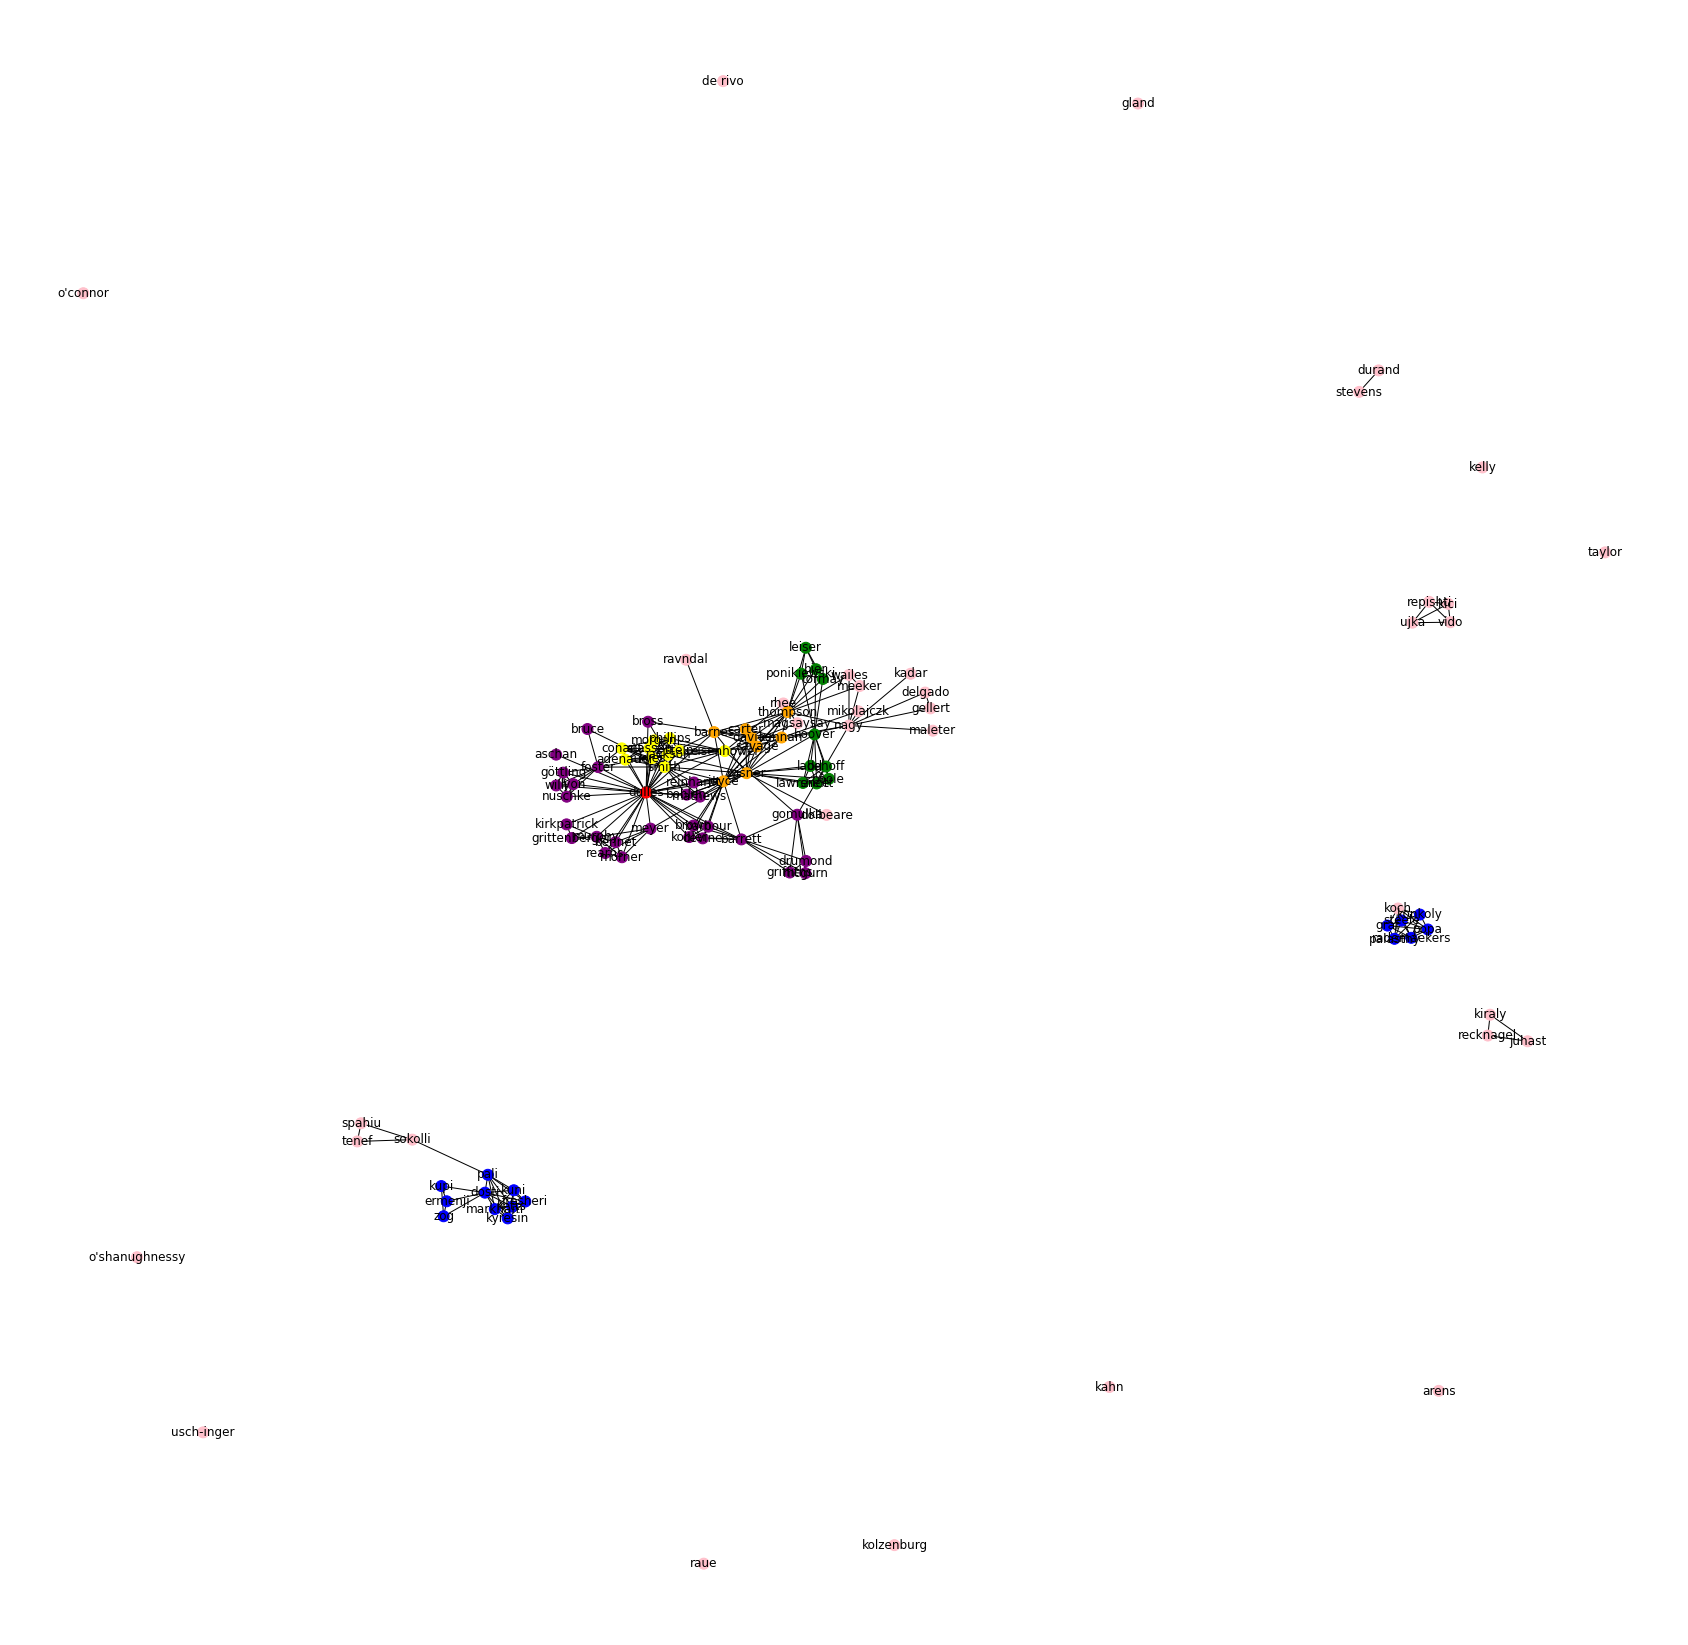

In [382]:

fig, ax = plt.subplots(figsize=(30,30))
nx.draw(baseG, node_color=color_map, node_size=120,  with_labels=True)
plt.show()

In [383]:
#pip install graphviz

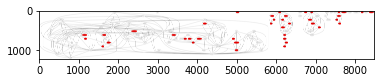

In [384]:
G = baseG
A = nx.nx_agraph.to_agraph(G)
A.node_attr['style']='filled'
A.write('colors.dot')
A.layout('dot')
A.draw('colors.png')
import matplotlib.image as mpimg
img = mpimg.imread('colors.png')
plt.imshow(img)
plt.show()

In [339]:
#pip install pygraphviz

In [385]:
#https://stackoverflow.com/questions/40266604/pip-install-pygraphviz-fails-failed-building-wheel-for-pygraphviz
#https://stackoverflow.com/questions/19674316/grouping-nodes-with-the-same-color-near-each-other-in-graphviz
#https://stackoverflow.com/questions/58518554/attributeerror-graph-object-has-no-attribute-node 


#https://stackoverflow.com/questions/27760956/setting-colour-of-nodes-in-pygraphviz
#https://stackoverflow.com/questions/13517614/draw-different-color-for-nodes-in-networkx-based-on-their-node-value
#https://stackoverflow.com/questions/19674316/grouping-nodes-with-the-same-color-near-each-other-in-graphviz

G = baseG

A = nx.nx_agraph.to_agraph(G)
A.node_attr['style']='filled'

red_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='red']
orange_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='orange']
yellow_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='yellow']
green_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='green']
blue_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='blue']
purple_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='purple']
pink_nodes = [n for n,d in G.nodes.items() if d.get('nodetype')=='pink']
A.add_subgraph(red_nodes, name = 'cluster1', color='red', style='filled')
A.add_subgraph(orange_nodes, name = 'cluster2', color='orange', style='filled')
A.add_subgraph(yellow_nodes, name = 'cluster3', color='yellow', style='filled')
A.add_subgraph(green_nodes, name = 'cluster4', color='green', style='filled')
A.add_subgraph(blue_nodes, name = 'cluster5', color='blue', style='filled')
A.add_subgraph(purple_nodes, name = 'cluster6', color='purple', style='filled')
A.add_subgraph(pink_nodes, name = 'cluster7', color='pink', style='filled')



A.write('colors.dot')
A.layout('dot')
A.draw('clustered-colors.png')


In [386]:
G.nodes()['dulles']
A.get_node('dulles').attr['fillcolor']

'white'

In [387]:
for n,d in G.nodes.items(): print(d.get('nodetype'))

yellow
pink
purple
purple
orange
purple
green
purple
purple
purple
purple
purple
orange
yellow
orange
pink
pink
purple
pink
blue
purple
red
pink
yellow
blue
purple
blue
pink
pink
purple
blue
purple
purple
purple
green
green
yellow
orange
pink
pink
pink
pink
orange
blue
pink
pink
purple
pink
purple
pink
blue
blue
blue
yellow
blue
green
green
green
purple
pink
pink
blue
purple
purple
pink
purple
pink
yellow
purple
purple
pink
purple
pink
pink
blue
blue
yellow
green
green
blue
blue
pink
pink
purple
pink
purple
pink
pink
orange
green
yellow
pink
pink
yellow
blue
yellow
pink
pink
pink
orange
green
pink
pink
pink
pink
purple
orange
blue


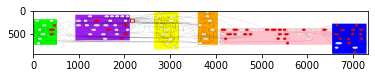

In [388]:
import matplotlib.image as mpimg
img = mpimg.imread('clustered-colors.png')
plt.imshow(img)
plt.show()

In [389]:
import pysbm
import networkx as nx
import matplotlib.pylab as pl

In [390]:
# https://github.com/funket/pysbm/blob/master/Example.ipynb

In [ ]:
graph = baseG

standard_partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=2)
degree_corrected_partition = pysbm.NxPartition(
    graph=graph, 
    number_of_blocks=2,
    representation=standard_partition.get_representation())
standard_objective_function = pysbm.TraditionalUnnormalizedLogLikelyhood(is_directed=False)
degree_corrected_objective_function = pysbm.DegreeCorrectedUnnormalizedLogLikelyhood(is_directed=False)

In [ ]:
fig, ax = plt.subplots(figsize=(30,30))
nx.draw(graph, position, with_labels = True, ax=ax, node_size=60, font_size=25, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()


In [ ]:
fig, ax = plt.subplots(figsize=(50,50))
nx.draw(graph, position, with_labels = True, ax=ax, node_size=60, font_size=25, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()

In [ ]:
standard_inference = pysbm.MetropolisHastingInference(graph, standard_objective_function, standard_partition)
degree_corrected_inference = pysbm.MetropolisHastingInference(graph, degree_corrected_objective_function, degree_corrected_partition)

In [ ]:
standard_inference.infer_stochastic_block_model()
degree_corrected_inference.infer_stochastic_block_model()

In [ ]:
fig, ax = plt.subplots(figsize=(50,50))

print("Standard SBM with the splitting into high and low degree nodes")
nx.draw(graph, position, ax=ax, with_labels = True, node_size=60, font_size=25, node_color=['r' if standard_partition.get_block_of_node(node) == 0 else 'b' for node in graph])
pl.show()


Degree Corrected SBM


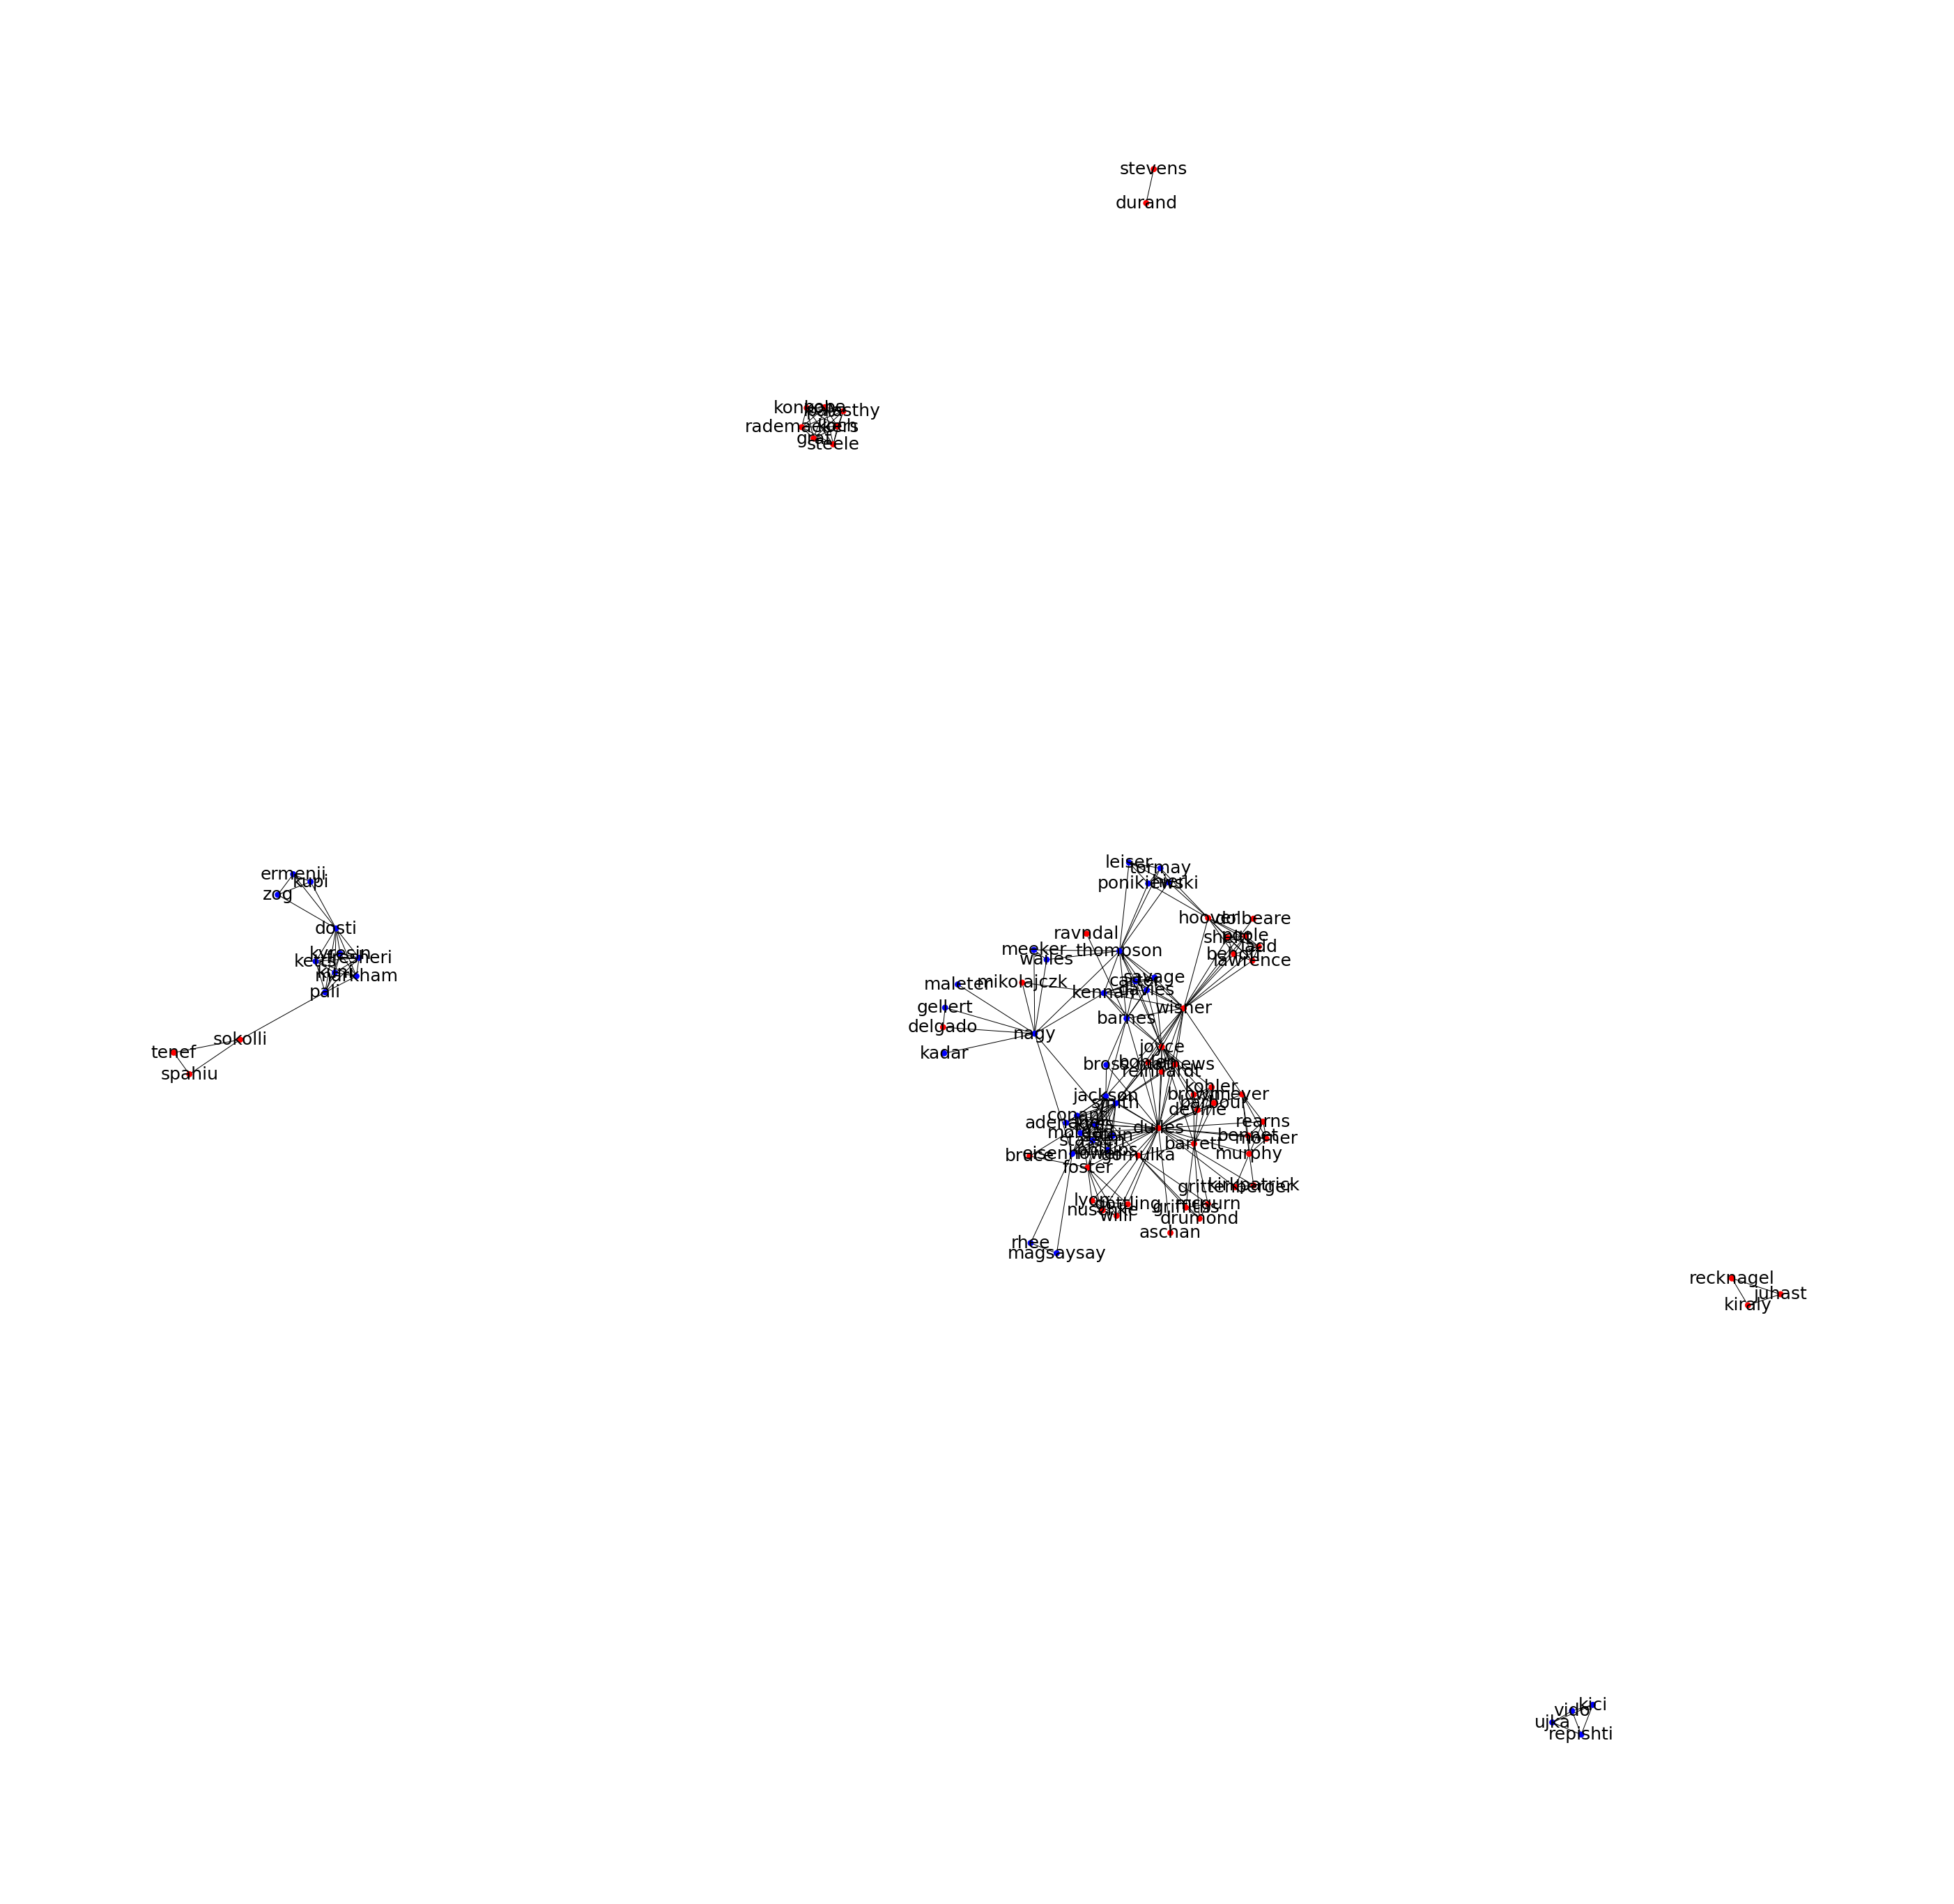

In [113]:
fig, ax = plt.subplots(figsize=(50,50))
print("Degree Corrected SBM")
nx.draw(graph, position, ax=ax, with_labels = True, node_size=60, font_size=25, node_color=['r' if degree_corrected_partition.get_block_of_node(node) == 0 else 'b' for node in graph])

pl.show()